In [1]:
from MLE_functions import *
from scipy.io import loadmat
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt


from jax import config
config.update("jax_enable_x64", True)

tolerance = 1e-5

########## System parameters

n_ab = ((2,2,2),(2,2,2),(2,2,2)) #n_ab = [[na1,na2,na3],[nb1,nb2,nb3]]

M = 3 #number of systems
N = 500 #number of samples;
obs = [1,2,3]
n_obs = len(obs)

N_A = M*N
N_o = n_obs*N

#Interconections
Upsilon_A = jnp.array([[0,0,0],[1,0,1],[0,1,0]])
Delta = jnp.array([[0,0],[1,0],[0,1]])


Upsilon_CA = jnp.array([[0,0,0],[0,0,1]])


########## Loading data:

data = loadmat('data/data_estimation.mat')


y6 = data["x"][2500:3000]
y3 = data["x"][1000:1500]
r = jnp.block([data["r"][:,0].reshape(-1,1), data["r"][:,1].reshape(-1,1)])
x = jnp.concatenate([data["x"][0:1500], data["x"][3500:5000]]).reshape(-1,1)


Upsilon_AC_y_C = np.block([[y6],[np.zeros((N,1))],[np.zeros((N,1))]])
Upsilon_CA_y_A = np.block([[np.zeros((N,1))],[y3]])


## Initial theta
theta_init = 0.1*jnp.ones(12)
c_init = jnp.array([0.1, 0.1])
n_ab_arx = ((2,2,2),(2,2,2))




r_sig = jnp.concatenate([r[:,0],r[:,1]]).reshape(-1,1)

xo,_,Permut = get_xoxm(x,obs,N,M)

A2,B2,U,V,N_F,N_H = gen_A2B2_feedback_AC(Upsilon_A, Delta, r_sig, Upsilon_CA, Permut, N, Upsilon_AC_y_C, N_A,Upsilon_CA_y_A)
A2o = A2[:,:N_o]
A2m = A2[:,N_o:]

To_phi, Tm_phi, T_gamma, W2, V2 = get_transform_matrices(A2o,A2m,B2)


In [6]:


@jit
def f_CMLE_arx(theta):
    f = eval_cost_func_feedback_AC(theta,n_ab_arx,Permut,Upsilon_A,U,V,N,N_F,N_H,To_phi, Tm_phi, T_gamma, W2, xo)
    f = jnp.where(jnp.isnan(f), 1.0e13, f)
    return f


@jit
def g_CMLE_arx(theta):
    return grad_theta_feedback_AC(theta,n_ab_arx,Permut,Upsilon_A,U,V,N,N_F,N_H,To_phi, Tm_phi, T_gamma, W2, xo).reshape(-1)


@jit
def H_CMLE_arx(theta):
    return Hessian_theta_feedback_AC(theta,n_ab_arx,Permut,Upsilon_A,U,V,N,N_F,N_H,To_phi, Tm_phi, T_gamma, W2, xo).reshape(theta.shape[0],theta.shape[0])


@jit
def f_CMLE(theta):
    f = eval_cost_func_feedback_AC(theta,n_ab,Permut,Upsilon_A,U,V,N,N_F,N_H,To_phi, Tm_phi, T_gamma, W2, xo)
    f = jnp.where(jnp.isnan(f), 1.0e13, f)
    return f


@jit
def g_CMLE(theta):
    return grad_theta_feedback_AC(theta,n_ab,Permut,Upsilon_A,U,V,N,N_F,N_H,To_phi, Tm_phi, T_gamma, W2, xo).reshape(-1)


@jit
def H_CMLE(theta):
    return Hessian_theta_feedback_AC(theta,n_ab,Permut,Upsilon_A,U,V,N,N_F,N_H,To_phi, Tm_phi, T_gamma, W2, xo).reshape(theta.shape[0],theta.shape[0])



In [7]:
theta = 0.1*jnp.ones(12)
n_ab = ((2,2,2),(2,2,2))


In [8]:
eval_cost_func_feedback_AC(theta,n_ab_arx,Permut,Upsilon_A,U,V,N,N_F,N_H,To_phi, Tm_phi, T_gamma, W2, xo)

Array(-319.25683982, dtype=float64)

In [9]:
theta_init

Array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],      dtype=float64)

In [10]:
result = minimize(fun=f_CMLE_arx, x0=theta, method='trust-constr', jac=g_CMLE_arx, hess=H_CMLE_arx, options={'verbose': 2,'maxiter':1000})
theta_arx = result.x.reshape(-1)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -3.1926e+02 | 1.00e+00 | 9.22e+02 | 0.00e+00 |
|   2   |   2   |   1   | -1.1945e+03 | 2.00e+00 | 1.98e+03 | 0.00e+00 |
|   3   |   3   |   2   | -1.1945e+03 | 1.00e+00 | 1.98e+03 | 0.00e+00 |
|   4   |   4   |   3   | -1.1945e+03 | 5.00e-01 | 1.98e+03 | 0.00e+00 |
|   5   |   5   |   4   | -1.2274e+03 | 5.00e-01 | 1.73e+03 | 0.00e+00 |
|   6   |   6   |   5   | -1.2494e+03 | 5.00e-01 | 2.13e+03 | 0.00e+00 |
|   7   |   7   |   6   | -1.2494e+03 | 2.50e-01 | 2.13e+03 | 0.00e+00 |
|   8   |   8   |   7   | -1.9579e+03 | 5.00e-01 | 4.04e+02 | 0.00e+00 |


KeyboardInterrupt: 

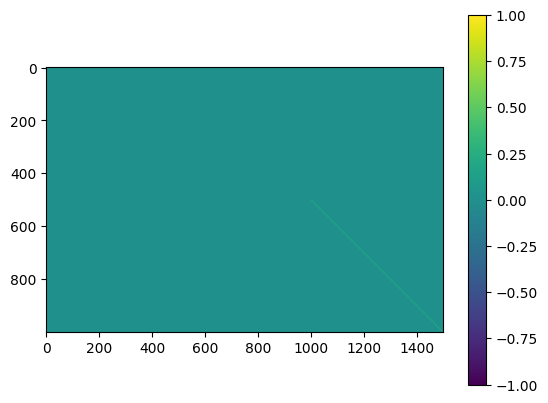

In [76]:
plt.imshow(np.kron(Upsilon_CA,jnp.eye(N))@U)
plt.colorbar()

In [78]:
B2 = np.linalg.inv(H)@np.block([[-Upsilon_CA2_bar.T@Upsilon_CA_y_A], [-jnp.kron(Delta,np.eye(N))@r_sig-Upsilon_AC_y_C]])


In [79]:
B2

array([[-0.1939169 ],
       [-0.04772029],
       [-0.05963846],
       ...,
       [-1.        ],
       [-1.        ],
       [ 1.        ]])